# Ornstein–Uhlenbeck Process Simulator Project
### *Simulation, MLE Estimation & Real Data Application*
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook & Research Motivation**:

Take the Ornstein–Uhlenbeck (OU) process from mathematics to practical financial modelling.

**This notebook**: 

- Simulate OU paths using Euler discretization.
- Recall Maximum Likelihood Estimation (MLE) on a simple Gaussian model (warm-up).
- Derive the OU transition density and build the log-likelihood function.
- Estimate OU parameters (θ, μ, σ) using real financial data (S&P 500 volatility, EUR/USD FX).
- Simulate future OU distributions and compare real vs model-generated time series.
- Extend a real series into the future by concatenating simulated OU data.

This is a full pipeline:
**SDE → simulation → transition density → MLE → calibration → scenario generation → model validation.**

# 1. Imports

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import scipy.stats as stats
from scipy.optimize import minimize
import yfinance as yf
import datetime
from IPython.display import display, Latex
import warnings
warnings.filterwarnings('ignore')

# 2. Ornstein–Uhlenbeck Process

${\Large dX_{t}=\theta (\mu -X_{t})dt+\sigma dW_{t}}$

$\theta$ : speed of mean reversion

$\mu$ : long-run mean

$\sigma$ : volatility

$W_t$ : standard Brownian motion

**Euler-Maruyama Discretization**

$\Large X_{t+\Delta t} = X_t + \theta(\mu - X_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$             
where $\epsilon_t \sim \mathcal{N}(0,1)$


In [241]:
def simulate_ou_process(X0, T, dt, theta, mu, sigma, M, seed=False):

    N = int(T / dt)
    t = np.arange(0, T, dt)
    X = np.zeros((M, N))
    X[:, 0] = X0

    if seed:
        np.random.seed(42)

    for i in range(1, N):
        X[:, i] = X[:, i - 1] + theta * (
            mu - X[:, i - 1]
        ) * dt + sigma * np.sqrt(dt) * np.random.normal(size=M)

    return t, X

In [242]:
def plot_ou_simulation(t, X):
    plt.figure(figsize=(20, 5))
    for j in range(X.shape[0]):
        plt.plot(t, X[j], color='purple')
    plt.title("Simulation of the Ornstein–Uhlenbeck Process")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

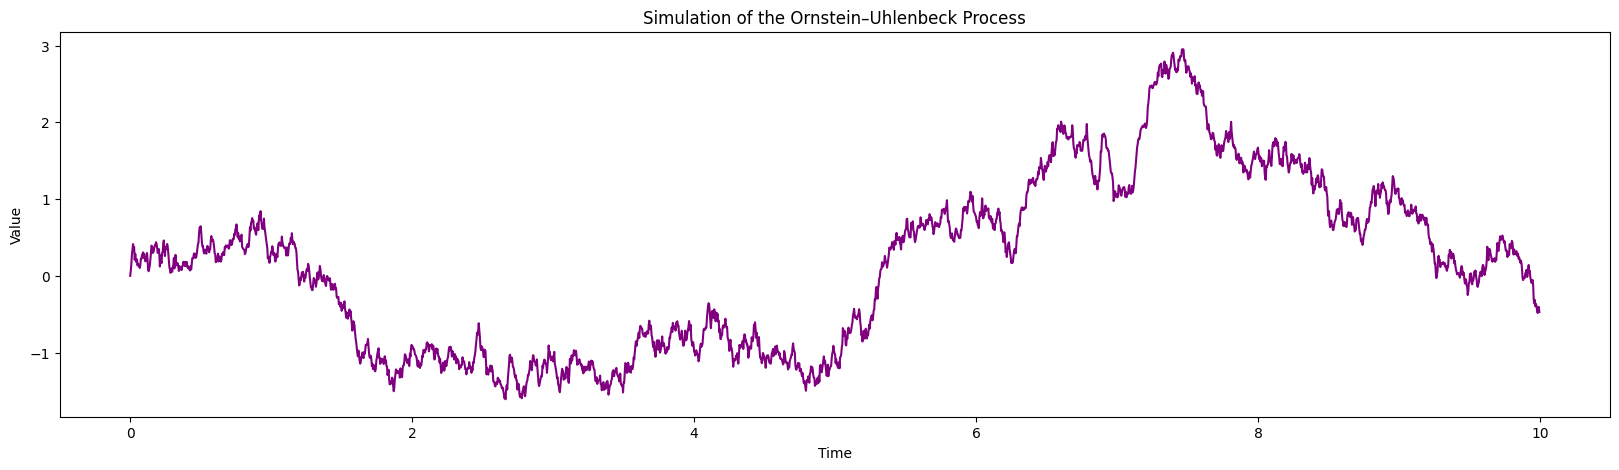

In [243]:
theta = 1
mu = 0
sigma = 1
X0 = 0
T = 10
dt = 1 / 252
M = 1

t, X = simulate_ou_process(X0, T, dt, theta, mu, sigma, M)
plot_ou_simulation(t, X)

# 3. Maximum Likelihood Estimation

Before estimating OU parameters, we review MLE on a simple Gaussian distribution.

**Normal density**

$$\Large f_\theta(x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{(x-\mu)^2}{2 \sigma^2}}$$

**Likelihood**

$$\Large L(\theta) = \prod^n_{i=1}f(X_i|\theta)$$

**MLE**

$$\Large \hat{\theta}(x) = \arg \max_{\theta} L(\theta|x)$$

In [244]:
def plot_normal_distribution(mu=0, sigma=1, num_points=100, estimate=False):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, num_points)
    y = stats.norm.pdf(x, loc=mu, scale=sigma)

    mu_rounded = round(mu, 4)
    sigma_rounded = round(sigma, 4)

    if estimate:
        plt.plot(
            x, y, label=f'$\\hat{{\\mu}}={mu_rounded}$, $\\hat{{\\sigma}}={sigma_rounded}$'
        )
    else:
        plt.plot(x, y, label=f'$\\mu={mu_rounded}$, $\\sigma={sigma_rounded}$')
    plt.title("Normal Distribution")
    plt.xlabel("Standard Deviations")
    plt.ylabel("Density")
    plt.legend()

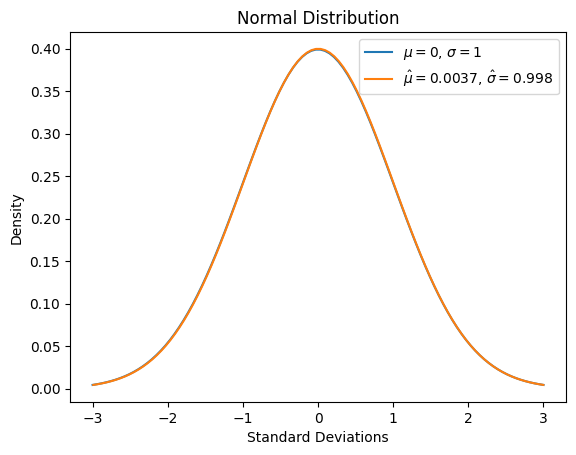

In [245]:
plot_normal_distribution()

N = 100000

X = np.random.normal(loc=0, scale=1, size=(N, ))

mu_estimate = X.mean()
sigma_estimate = X.std()

plot_normal_distribution(mu_estimate, sigma_estimate, estimate=True)

# 4. OU Transition Density via Itô Calculus

Starting from

${\Large dX_{t}=\theta (\mu -X_{t})dt+\sigma dW_{t}}$

Linearization

$\Large dX_t= \theta \mu dt -\theta X_t dt+\sigma dW_t$

$\Large dX_t + \theta X_t dt = \theta \mu dt + \sigma dW_t$

Integrating factor

$\int^T_0 d(e^{\theta t} X_t) = \int^T_0 \theta \mu e^{\theta t} dt + \int^T_0 \sigma e^{\theta t} dW_t$

Solution

$\Large X_T = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T}) + \sigma \int^T_0 e^{-\theta (T-t)} dW_t$

Expectation

$\Large E[X_T] = X_0 e^{-\theta T} + \mu (1 - e^{-\theta T})$

Variance

$\Large Var[X_T] = \frac{\sigma^2}{2 \theta}(1-e^{-2\theta T})$

Thus,

$\Large X_T \sim \mathcal{N}(E[X_T], Var[X_T])$

Exact transition:

$\Large X_{t+\Delta t} = X_t e^{-\theta \Delta t} + \mu (1 - e^{-\theta \Delta t}) + \sigma \sqrt{\frac{(1-e^{-2\theta \Delta t})}{2 \theta}} \mathcal{N}(0,1)$

# 5. MLE for the OU Process

OU conditional distribution:

$\Large X_{t+\delta t} \sim \mathcal{N}(\overline{\mu}, \overline{\sigma}^2)$

Where:

$\Large \overline{\mu}(x_t, \theta, \mu) = x_t e^{-\theta \delta t} + \mu (1 - e^{-\theta \delta t})$

$\Large \overline{\sigma}^2(\theta, \sigma) = \frac{\sigma^2}{2\theta}(1 - e^{-2\theta \delta t})$

In [246]:
def _mu(x, dt, theta, mu):
    ett = np.exp(-theta * dt)
    return x * ett + mu * (1 - ett)

$\Large \overline{\sigma}(\theta, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\theta \delta t})}{2 \theta}}$

In [247]:
def _sigma(dt, theta, sigma):
    e2tt = np.exp(-2 * theta * dt)
    return sigma * np.sqrt((1 - e2tt) / (2 * theta))

Log-likelihood

$\Large l(\theta) = \sum^N_{i=1} \log f_\theta (x_i)$

In [248]:
def log_likelihood(theta_estimate, x, dt=1/252):
    theta = theta_estimate[0]
    mu    = theta_estimate[1]
    sigma = theta_estimate[2]

    x = np.asarray(x)
    x_dt = x[1:]
    x_t  = x[:-1]

    mu_OU    = _mu(x_t, dt, theta, mu)
    sigma_OU = _sigma(dt, theta, sigma)

    # Numerical stability
    sigma_OU = np.maximum(sigma_OU, 1e-8)

    log_pdf = stats.norm.logpdf(x_dt, loc=mu_OU, scale=sigma_OU)
    return -np.sum(log_pdf)


Optimization:

In [249]:
def optimize_ou_parameters(data, theta0=None):
    x = np.asarray(data)

    if theta0 is None:
        theta0 = [
            0.5,             # theta initial guess
            float(x.mean()), # mu ~ empirical mean
            float(x.std())   # sigma ~ empirical standard deviation
        ]

    bounds = [
        (1e-6, None),  # theta > 0
        (None, None),  # mu free
        (1e-6, None)   # sigma > 0
    ]

    res = minimize(
        fun=log_likelihood,
        x0=theta0,
        args=(x,),
        bounds=bounds,
        method='L-BFGS-B'
    )
    return res

Output:

In [250]:
def estimate_ou_parameters(data, theta0=None):

    res = optimize_ou_parameters(data, theta0)

    print(res.message, res.success)   # debug

    theta = round(res.x[0], 3)
    mu    = round(res.x[1], 3)
    sigma = round(res.x[2], 3)

    theta_estimate_ = fr'$\Large \hat{{\theta}} = {theta}$'
    mu_estimate_    = fr'$\Large \hat{{\mu}} = {mu}$'
    sigma_estimate_ = fr'$\Large \hat{{\sigma}} = {sigma}$'

    display(Latex(theta_estimate_))
    display(Latex(mu_estimate_))
    display(Latex(sigma_estimate_))

    return theta, mu, sigma

# 6. Application 1: S&P 500 Realized Volatility

[*********************100%***********************]  1 of 1 completed


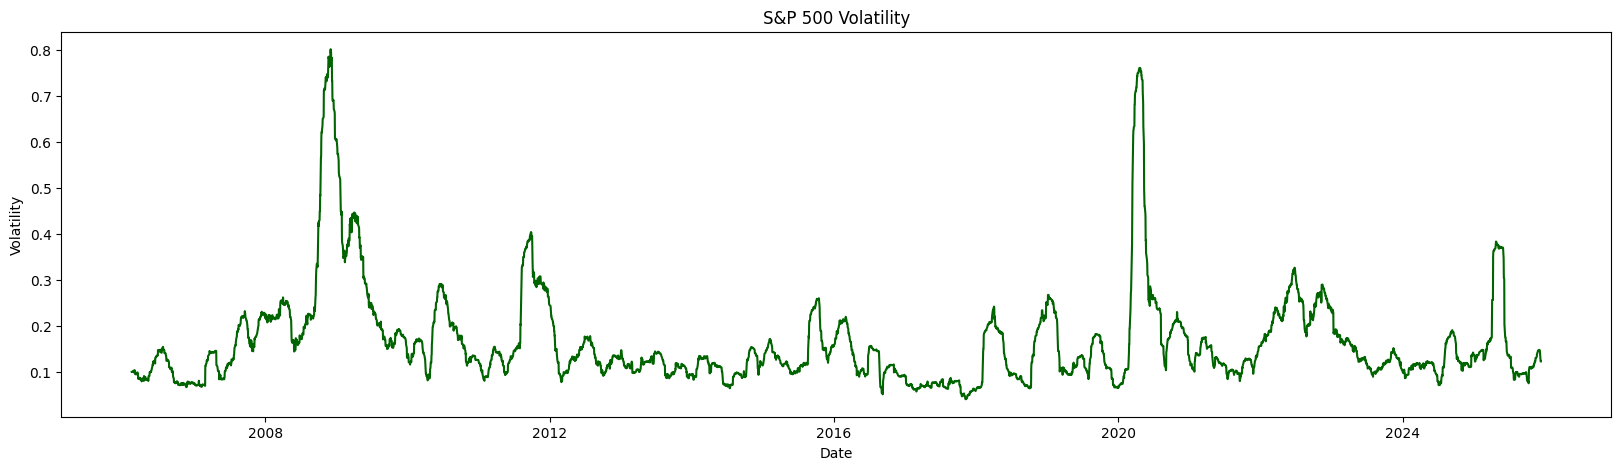

In [251]:
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=7300)

prices_ohlc = yf.download('^GSPC', start_date, end_date)
sp_log_returns = np.log(prices_ohlc.Close / prices_ohlc.Close.shift(1)).dropna()

sp_volatility = (sp_log_returns.rolling(window=40).std() *np.sqrt(252)).dropna()

plt.figure(figsize=(20, 5))
plt.plot(sp_volatility.index, sp_volatility['^GSPC'], color='darkgreen')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('S&P 500 Volatility')
plt.show()

Parameters estimation:

In [252]:
theta_sp, mu_sp, sigma_sp = estimate_ou_parameters(sp_volatility)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH True


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## 6.1 Simulating the Exact OU Distribution

In [253]:
def simulate_continuous_ou_process(X0, T, theta, mu, sigma, M):
    X0 = float(X0)
    theta = float(theta)
    mu    = float(mu)
    sigma = float(sigma)
    T     = float(T)

    Z = np.random.normal(size=M)
    drift_OU = _mu(X0, T, theta, mu)
    diffusion_OU = _sigma(T, theta, sigma)

    if np.isnan(drift_OU) or np.isnan(diffusion_OU):
        raise ValueError("drift_OU or diffusion_OU is NaN — check parameters and _sigma/_mu.")

    return drift_OU + diffusion_OU * Z

Density plot:

In [254]:
def plot_kde(data, title="Title", xlabel="x", ylabel="y"):
    data = np.asarray(data).ravel()
    df = pd.DataFrame({"x": data})
    kde = stats.gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    kde_vals = kde(x_vals)
    mode_peak = x_vals[np.argmax(kde_vals)]

    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x="x", fill=True)
    plt.axvline(mode_peak, linestyle='--', label=f'Mode: {mode_peak:.2f}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

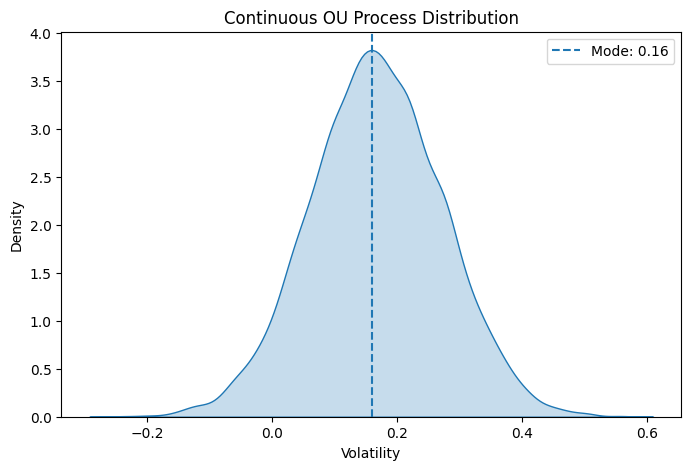

In [255]:
T = 10
M = 10000
X0 = sp_volatility.iloc[-1]

# Simulate the continuous-time OU distribution at horizon T
simulated_data = simulate_continuous_ou_process(X0, T, theta_sp, mu_sp, sigma_sp, M)

# Plot the empirical KDE of simulated values
plot_kde(simulated_data,
         title="Continuous OU Process Distribution",
         xlabel="Volatility",
         ylabel="Density")


## 6.2. Comparing Real vs OU Data

In [256]:
def simulate_and_compare_data(
    data, theta, mu, sigma, start_date=None, M=1, seed=False
):
    """
    data : Series (with date index) OR DataFrame with 1 column OR 1D/(N,1) array
    """

    # Normalize data to 1D values + optionally a time index
    if isinstance(data, pd.Series):
        series = data.dropna()
        values = series.values          # 1D numpy
        index = series.index            # real time index
        has_index = True

    elif isinstance(data, pd.DataFrame):
        # Take the first column
        series = data.iloc[:, 0].dropna()
        values = series.values
        index = series.index
        has_index = True

    else:
        # numpy array or other → force to 1D
        arr = np.asarray(data)
        values = arr.ravel()
        # remove any NaNs
        mask = ~np.isnan(values)
        values = values[mask]
        index = None
        has_index = False

    # Time parameters
    T = len(values) / 252
    dt = 1 / 252

    # Initial condition = first observed value
    X0 = float(values[0])

    # Simulation of an OU path
    t, OU = simulate_ou_process(X0, T, dt, theta, mu, sigma, M, seed=seed)
    OU = OU[0]          # 1D path

    # Align lengths
    min_length = min(len(OU), len(values))
    OU_aligned = OU[-min_length:]
    real_aligned = values[-min_length:]

    # Time index: either keep the data's index or reconstruct it
    if has_index:
        time_index = index[-min_length:]
    else:
        if start_date is not None:
            time_index = pd.date_range(start=start_date, periods=min_length, freq='B')
        else:
            time_index = np.arange(min_length)

    # Comparison of statistics
    def compare_statistics(real_data, simulated_data):
        stats_comparison = {
            "Mean": (np.mean(real_data), np.mean(simulated_data)),
            "Standard deviation": (np.std(real_data), np.std(simulated_data)),
            "Skewness": (stats.skew(real_data), stats.skew(simulated_data)),
            "Kurtosis": (stats.kurtosis(real_data), stats.kurtosis(simulated_data))
        }
        return pd.DataFrame(
            stats_comparison, index=["Real Data", "OU Process"]
        )

    print(compare_statistics(real_aligned, OU_aligned))

    # Comparative plot
    plt.figure(figsize=(20, 5))
    plt.plot(time_index, OU_aligned, label="OU Process", color='purple')
    plt.plot(time_index, real_aligned, label="Real Data", color='darkgreen')
    plt.title("OU Process vs Real Data")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()

                Mean  Standard deviation  Skewness   Kurtosis
Real Data   0.164598            0.107432  2.984337  11.642252
OU Process  0.184783            0.084805 -1.033314   2.678481


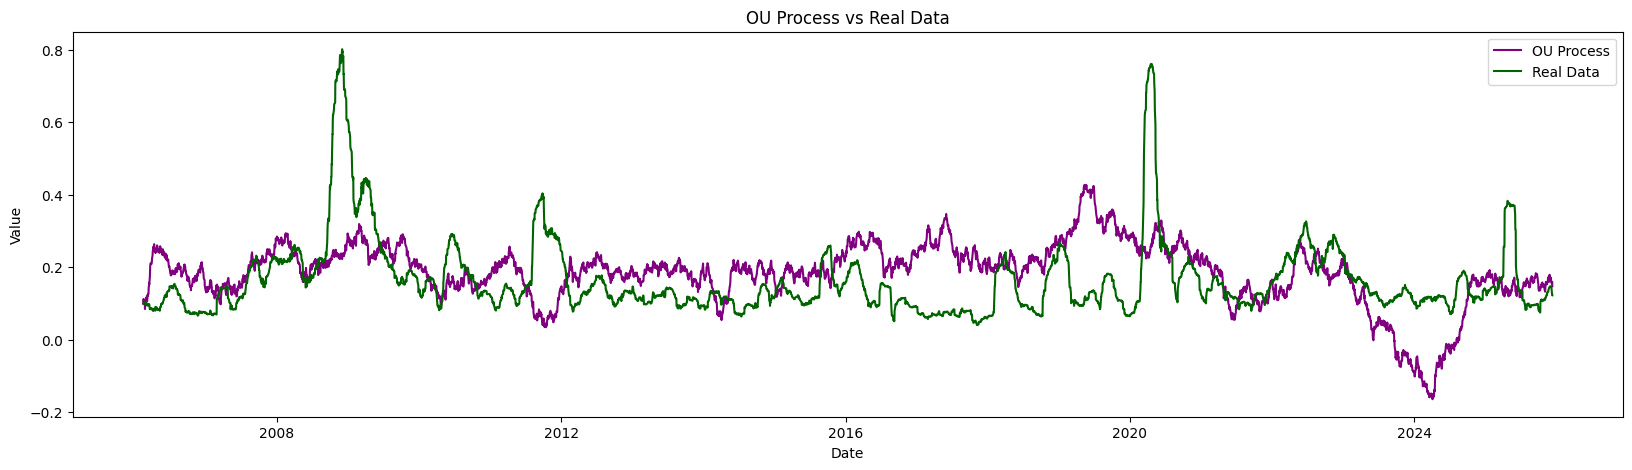

In [257]:
simulate_and_compare_data(sp_volatility, theta_sp, mu_sp, sigma_sp, start_date)

# 7. Application 2: EUR/USD Exchange Rate

In [258]:
end_date = datetime.datetime.now()
start_date_fx = end_date - datetime.timedelta(days=7300)

prices_ohlc = yf.download('EURUSD=X', start=start_date_fx, end=end_date)
eurusd_close = prices_ohlc['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


Parameters estimation :

In [259]:
theta_fx, mu_fx, sigma_fx = estimate_ou_parameters(eurusd_close)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH True


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

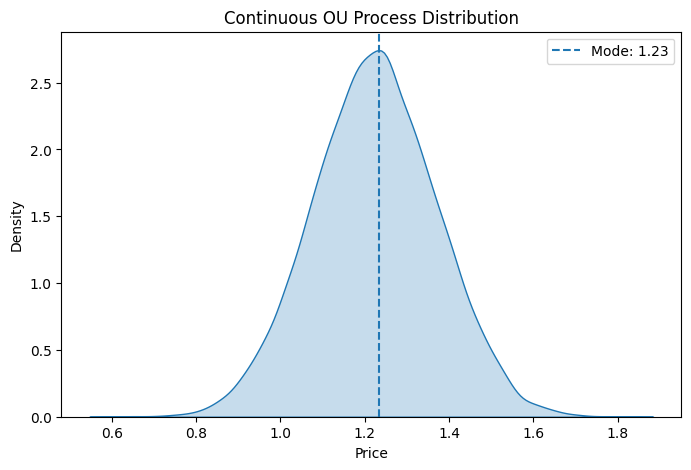

In [260]:
T = 10
M = 10000
X0 = eurusd_close.iloc[-1]

simulated_data_fx = simulate_continuous_ou_process(X0, T, theta_fx, mu_fx, sigma_fx, M)

plot_kde(
    simulated_data_fx,
    title="Continuous OU Process Distribution",
    xlabel="Price",
    ylabel="Density"
)

                Mean  Standard deviation  Skewness  Kurtosis
Real Data   1.222969            0.132815  0.516139 -0.610636
OU Process  1.291296            0.139740 -0.080139 -0.900490


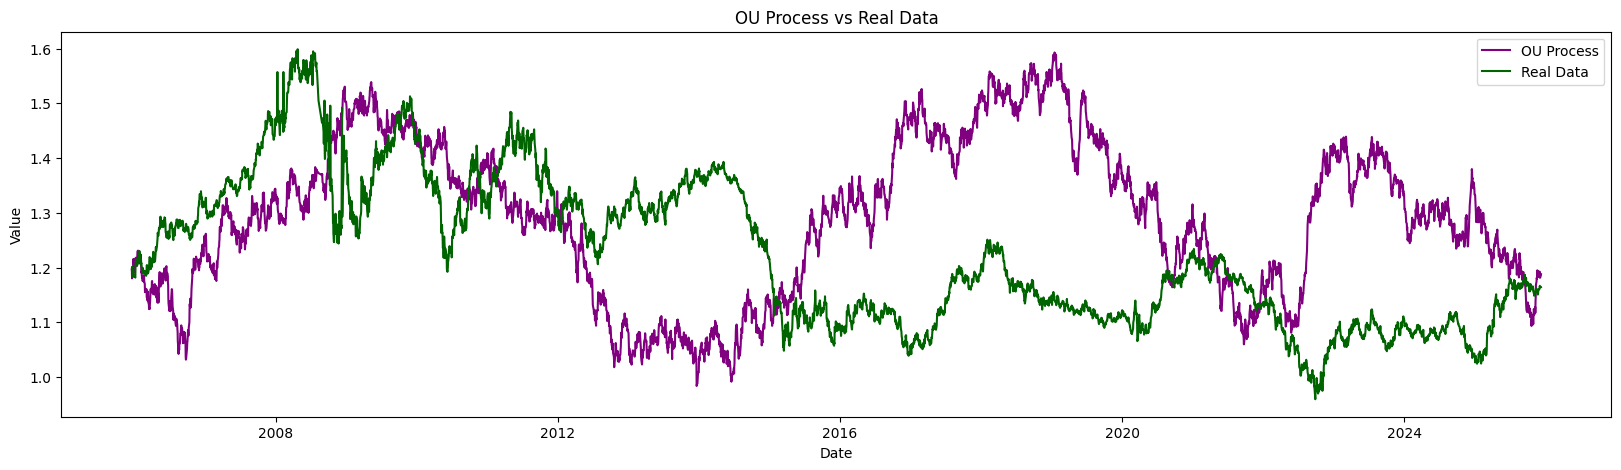

In [261]:
simulate_and_compare_data(eurusd_close, theta_fx, mu_fx, sigma_fx, start_date)

# 8. Extending a Time Series with Simulated OU Data

In [262]:
def simulate_and_concatenate_data(
    data, theta, mu, sigma, start_date=None, M=1, seed=False
):
    # Normalization of input into clean Series + 1D values
    if isinstance(data, pd.Series):
        series = data.dropna()
        values = series.values
        index_real = series.index
    elif isinstance(data, pd.DataFrame):
        series = data.iloc[:, 0].dropna()
        values = series.values
        index_real = series.index
    else:
        arr = np.asarray(data).ravel()
        mask = ~np.isnan(arr)
        values = arr[mask]
        index_real = None

    # Time parameters
    T = len(values) / 252
    dt = 1 / 252

    # Initial condition = last observed value
    X0 = float(values[-1])

    # 3) Simulate an OU path
    t, OU = simulate_ou_process(X0, T, dt, theta, mu, sigma, M, seed=None)
    OU = OU[0]  # 1D path

    ou_length = len(OU)

    # Construct the time index
    if index_real is not None:
        time_index_real = index_real
        time_index_ou = pd.date_range(
            start=time_index_real[-1] + pd.Timedelta(days=1),
            periods=ou_length,
            freq='B'
        )
    else:
        if start_date is None:
            start_date = datetime.datetime.now()
        time_index_real = pd.date_range(
            start=start_date, periods=len(values), freq='B'
        )
        time_index_ou = pd.date_range(
            start=time_index_real[-1] + pd.Timedelta(days=1),
            periods=ou_length,
            freq='B'
        )

    # Concatenate real data + OU
    concatenated_data = np.concatenate((values, OU))
    concatenated_time_index = time_index_real.append(time_index_ou)

    concatenated_series = pd.Series(
        concatenated_data, index=concatenated_time_index
    )

    return concatenated_series

In [263]:
def plot_concatenated_series(
    concatenated_series,
    ou_start_date,
    title="Extended Series",
    xlabel="Time",
    ylabel="Value"
):
    plt.figure(figsize=(20, 5))

    # Plot total series
    plt.plot(concatenated_series.index, concatenated_series,
             label="Real Data + OU Simulation", color="steelblue")

    # Vertical red dashed line
    plt.axvline(
        x=ou_start_date,
        color="red",
        linestyle="--",
        linewidth=2,
        label="OU Start (today)"
    )

    # Highlight OU region with a transparent red box
    plt.axvspan(
        ou_start_date,
        concatenated_series.index[-1],
        color="red",
        alpha=0.10,
        label="OU Simulation Zone"
    )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

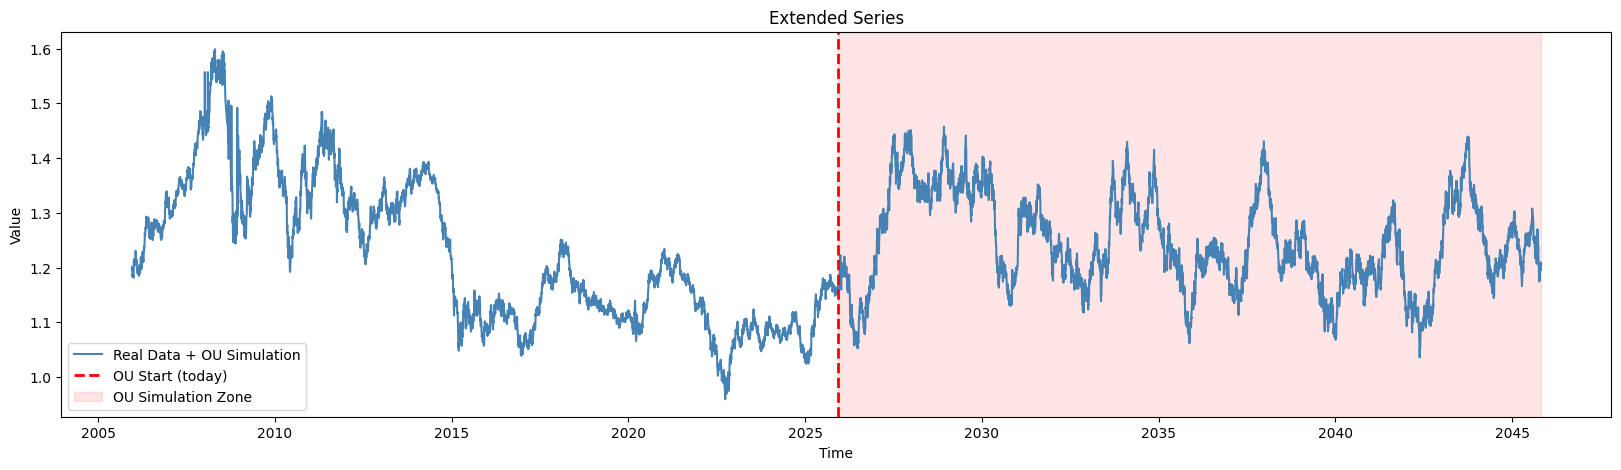

In [264]:
# Concat
concatenated_series = simulate_and_concatenate_data(
    eurusd_close, theta_fx, mu_fx, sigma_fx, start_date, seed=True
)

ou_start_date = concatenated_series.index[len(eurusd_close)]
plot_concatenated_series(concatenated_series, ou_start_date)